# Project 2 - Forecasting Service Metrics

Authors: Tatiana Barrios, Anisha Anandkrishnan

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from pandas import concat
import seaborn as sns

%matplotlib inline

1.Data preparation: Use one of the methods described in Project 1 (Advanced), Task 1 to pre-process the trace. Remove possible outliers. Reduce the dimensionality of the feature space to k = 16 using tree-based feature selection. Then, split the processed trace into training and test samples (x(t),y(t)) by assigning the samples with t < T to the training set and t ≥T to the test set. T is chosen so that the training set contains 70% of the samples.

# Task II - Using Recurrent Neural Networks (RNNs) for forecasting

In [48]:
X = pd.read_csv('X.csv')
Y = pd.read_csv('Y.csv')
X.index = pd.to_datetime(X['TimeStamp'])
Y.index = pd.to_datetime(Y['TimeStamp'])
X_dropped = X.drop(labels=["Unnamed: 0", "TimeStamp"], axis=1, inplace=False)
Y_dropped = Y.drop(labels=["Unnamed: 0", "TimeStamp"], axis=1, inplace=False)
X_preprocessed = pd.DataFrame()
X_tmp = preprocessing.StandardScaler().fit_transform(X_dropped)
for i, n in enumerate(X_dropped):
        X_preprocessed[n] = X_tmp[:, i]
        
X_preprocessed.head()

/home/anisha/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/anisha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,0_all_..usr,0_all_..sys,0_all_..iowait,0_all_..soft,0_all_..idle,0_cpu0_.usr,0_cpu0_.sys,0_cpu0_.iowait,0_cpu0_.soft,0_cpu0_.idle,...,36_RxBytes.1,36_TxBytes.1,40_RxPacktes.1,40_TxPacktes.1,40_RxBytes.1,40_TxBytes.1,41_RxPacktes.1,41_TxPacktes.1,41_RxBytes.1,41_TxBytes.1
0,0.069116,1.088334,0.766004,0.573967,-0.579449,1.364018,0.977205,-0.00831,-0.355042,-2.078731,...,1.583733,1.335871,1.090350,1.069987,1.211176,0.975349,1.053685,1.064968,0.971475,1.180097
1,0.247507,2.503497,0.377145,0.573967,-0.865816,1.364018,4.193380,-0.00831,-0.355042,-2.078731,...,1.551250,1.485179,1.190029,1.263907,1.110672,1.287438,1.269613,1.224345,1.294599,1.157325
2,0.158311,1.421314,0.571574,-0.290273,-0.579449,1.384053,0.993448,-0.00831,-0.355042,-1.518028,...,1.636638,1.320954,1.119925,1.012137,1.234329,0.859493,1.037388,1.111521,0.901761,1.236388
3,0.425898,1.421314,0.766004,3.382748,-1.135338,1.404089,-0.630882,-0.00831,2.626215,-0.945519,...,1.503362,1.510045,1.144023,1.126207,1.215636,1.070883,1.113167,1.141096,1.054886,1.212100
4,0.158311,0.006151,5.432315,1.654267,-2.129200,2.355777,2.585292,-0.00831,-0.355042,-2.078731,...,1.556992,1.341298,1.134713,1.095245,1.194114,1.050206,1.113574,1.146025,1.094834,1.186764


In [49]:
X_preprocessed.shape

(14481, 1751)

In [50]:
#converting Y_dropped to make it of the same form as X_preprocessed
Y_new = pd.DataFrame()
Y_tmp=Y_dropped.to_numpy()

for i, n in enumerate(Y_dropped):
        Y_new[n] = Y_tmp[:, i]  
# outlier rejection   
remove = []
for i in X_preprocessed:
    for j in range(len(X_preprocessed[i])):
        if j not in remove and abs(X_preprocessed[i][j]) > 80:
            remove.append(j)
X_clean = X_preprocessed.drop(labels=remove, axis=0, inplace=False)
Y_clean = Y_new.drop(labels=remove, axis=0, inplace=False)

print("Number of dropped samples: ", (len(remove)))
%store X_clean
%store Y_clean

Number of dropped samples:  136
Stored 'X_clean' (DataFrame)
Stored 'Y_clean' (DataFrame)


In [51]:
X_clean.shape

(14345, 1751)

In [52]:
X_clean = X_clean.reset_index()
Y_clean = Y_clean.reset_index()

In [53]:
X_clean = X_clean.drop(X_clean.columns[0], axis=1)
Y_clean = Y_clean.drop(Y_clean.columns[0], axis=1)

In [54]:
X_clean.head()

,0_all_..usr,0_all_..sys,0_all_..iowait,0_all_..soft,0_all_..idle,0_cpu0_.usr,0_cpu0_.sys,0_cpu0_.iowait,0_cpu0_.soft,0_cpu0_.idle,...,36_RxBytes.1,36_TxBytes.1,40_RxPacktes.1,40_TxPacktes.1,40_RxBytes.1,40_TxBytes.1,41_RxPacktes.1,41_TxPacktes.1,41_RxBytes.1,41_TxBytes.1
0,0.069116,1.088334,0.766004,0.573967,-0.579449,1.364018,0.977205,-0.00831,-0.355042,-2.078731,...,1.583733,1.335871,1.090350,1.069987,1.211176,0.975349,1.053685,1.064968,0.971475,1.180097
1,0.247507,2.503497,0.377145,0.573967,-0.865816,1.364018,4.193380,-0.00831,-0.355042,-2.078731,...,1.551250,1.485179,1.190029,1.263907,1.110672,1.287438,1.269613,1.224345,1.294599,1.157325
2,0.158311,1.421314,0.571574,-0.290273,-0.579449,1.384053,0.993448,-0.00831,-0.355042,-1.518028,...,1.636638,1.320954,1.119925,1.012137,1.234329,0.859493,1.037388,1.111521,0.901761,1.236388
3,0.425898,1.421314,0.766004,3.382748,-1.135338,1.404089,-0.630882,-0.00831,2.626215,-0.945519,...,1.503362,1.510045,1.144023,1.126207,1.215636,1.070883,1.113167,1.141096,1.054886,1.212100
4,0.158311,0.006151,5.432315,1.654267,-2.129200,2.355777,2.585292,-0.00831,-0.355042,-2.078731,...,1.556992,1.341298,1.134713,1.095245,1.194114,1.050206,1.113574,1.146025,1.094834,1.186764


In [55]:
Y_clean.head()

,ReadsAvg,WritesAvg
0,59.1331,118.7723
1,59.8588,118.4950
2,57.8251,116.8042
3,63.8154,128.3462
4,57.4993,118.2260


In [56]:
%store -r X_clean
%store -r Y_clean

#Reduce the dimensionality of the feature space 
tree = ExtraTreesRegressor(n_estimators=100, n_jobs=20)
tree = tree.fit(X_clean, Y_clean)
model = SelectFromModel(tree,prefit=True,max_features=16,threshold=-np.inf)
X_fs = model.transform(X_clean)
top_features = []
get_feat = model.get_support()
for i, n in enumerate(X_clean):
    if get_feat[i]:
        top_features.append(n)
feature_name = []
for i in range(16):
    feature_name.append('feature'+str(i+1)+" : "+top_features[i])
X_latest = pd.DataFrame(data = X_fs,columns= feature_name)
Y_latest = pd.DataFrame(data = Y_clean,columns= Y_dropped.columns)
Y_latest = Y_latest.drop(labels=["WritesAvg"], axis=1, inplace=False)
X_latest.head()
Y_latest.head()


,ReadsAvg
0,59.1331
1,59.8588
2,57.8251
3,63.8154
4,57.4993


In [57]:
X_latest.head()

,feature1 : 1_i127_intr.s,feature2 : 5_campg.s,feature3 : 4_RxPacktes,feature4 : 4_TxPacktes,feature5 : 15_RxPacktes,feature6 : 15_TxBytes,feature7 : 17_TxPacktes,feature8 : 29_TxBytes,feature9 : 41_TxBytes,feature10 : 4_RxPacktes.1,feature11 : 4_TxPacktes.1,feature12 : 4_TxBytes.1,feature13 : 15_RxPacktes.1,feature14 : 17_TxPacktes.1,feature15 : 40_RxPacktes.1,feature16 : 41_TxBytes.1
0,1.119895,0.019228,1.039869,1.088463,1.028539,1.184277,1.034312,1.165585,1.180097,1.039869,1.088463,1.214220,1.028539,1.034312,1.090350,1.180097
1,0.855128,0.051963,1.299455,1.238908,1.247687,1.219757,1.238812,1.201460,1.157325,1.299455,1.238908,1.194544,1.247687,1.238812,1.190029,1.157325
2,0.879198,0.043744,1.025629,1.115817,1.079864,1.105230,1.077493,1.237204,1.236388,1.025629,1.115817,1.240098,1.079864,1.077493,1.119925,1.236388
3,0.566292,0.022571,1.138740,1.127852,1.132818,1.172840,1.135340,1.189385,1.212100,1.138740,1.127852,1.187528,1.132818,1.135340,1.144023,1.212100
4,0.939372,0.048202,1.112293,0.980143,1.148704,1.167679,1.125563,1.219838,1.186764,1.112293,0.980143,1.005623,1.148704,1.125563,1.134713,1.186764


In [58]:
Y_latest.shape

(14345, 1)

In [59]:
Y_latest.tail()

,ReadsAvg
14476,55.6183
14477,52.6730
14478,52.1335
14479,52.1671
14480,52.6722


In [60]:
Y_latest = Y_latest.reset_index()

In [61]:
Y_latest = Y_latest.drop(Y_latest.columns[0], axis=1)

In [62]:
Y_latest.tail()

,ReadsAvg
14340,55.6183
14341,52.6730
14342,52.1335
14343,52.1671
14344,52.6722


In [63]:
#splitting the processed trace into training and test samples and time index sorting
X_train, X_test, Y_train, Y_test = train_test_split(X_latest, Y_latest, test_size=0.3, shuffle = False)
print(X_train.shape,"(70% of the samples in training set and 16 features)")
X_train = X_train.sort_index(axis = 0)
X_test = X_test.sort_index(axis = 0)
Y_train = Y_train.sort_index(axis = 0)
Y_test = Y_test.sort_index(axis = 0)


## T is the index 9285

(10041, 16) (70% of the samples in training set and 16 features)


In [64]:
X_train.tail()

,feature1 : 1_i127_intr.s,feature2 : 5_campg.s,feature3 : 4_RxPacktes,feature4 : 4_TxPacktes,feature5 : 15_RxPacktes,feature6 : 15_TxBytes,feature7 : 17_TxPacktes,feature8 : 29_TxBytes,feature9 : 41_TxBytes,feature10 : 4_RxPacktes.1,feature11 : 4_TxPacktes.1,feature12 : 4_TxBytes.1,feature13 : 15_RxPacktes.1,feature14 : 17_TxPacktes.1,feature15 : 40_RxPacktes.1,feature16 : 41_TxBytes.1
10036,1.083791,0.006552,0.890140,0.862522,0.860309,0.847371,0.848144,0.930262,0.941195,0.890140,0.862522,0.921023,0.860309,0.848144,0.876752,0.941195
10037,0.999547,0.024800,0.870610,0.846657,0.887601,0.845140,0.888474,0.898441,0.907049,0.870610,0.846657,0.905672,0.887601,0.888474,0.851011,0.907049
10038,0.975477,0.008223,0.833584,0.861975,0.874158,0.873696,0.874623,0.900591,0.922680,0.833584,0.861975,0.919101,0.874158,0.874623,0.871276,0.922680
10039,1.107860,0.042908,0.879968,0.880576,0.786581,0.913781,0.781335,0.919159,0.935334,0.879968,0.880576,0.925998,0.786581,0.781335,0.867989,0.935334
10040,1.023616,0.006970,0.860438,0.870728,0.971512,0.911640,0.955690,0.914619,0.892267,0.860438,0.870728,0.884023,0.971512,0.955690,0.883325,0.892267


In [65]:
X_test.head()

,feature1 : 1_i127_intr.s,feature2 : 5_campg.s,feature3 : 4_RxPacktes,feature4 : 4_TxPacktes,feature5 : 15_RxPacktes,feature6 : 15_TxBytes,feature7 : 17_TxPacktes,feature8 : 29_TxBytes,feature9 : 41_TxBytes,feature10 : 4_RxPacktes.1,feature11 : 4_TxPacktes.1,feature12 : 4_TxBytes.1,feature13 : 15_RxPacktes.1,feature14 : 17_TxPacktes.1,feature15 : 40_RxPacktes.1,feature16 : 41_TxBytes.1
10041,1.119895,0.007527,0.860438,0.841733,0.818353,0.933630,0.803333,0.932650,0.933608,0.860438,0.841733,0.926773,0.818353,0.803333,0.844439,0.933608
10042,1.180069,0.006830,0.862879,0.872369,0.868456,0.920929,0.854662,0.912441,0.910287,0.862879,0.872369,0.907818,0.868456,0.854662,0.863060,0.910287
10043,1.119895,0.008502,0.856776,0.919418,0.912855,0.883211,0.912101,0.868774,0.888634,0.856776,0.919418,0.882061,0.912855,0.912101,0.914543,0.888634
10044,0.975477,0.007248,0.833177,0.894252,0.811021,0.950526,0.819628,0.957691,0.949711,0.833177,0.894252,0.947562,0.811021,0.819628,0.895921,0.949711
10045,0.951407,0.043326,0.877120,0.851581,0.870492,0.898870,0.868105,0.891108,0.922233,0.877120,0.851581,0.919461,0.870492,0.868105,0.853202,0.922233


In [66]:
Y_test.head()

,ReadsAvg
10041,59.4228
10042,59.7941
10043,59.6689
10044,58.4393
10045,57.2402


1. The goal of this task is to find a non-linear, LSTM model to forecast the target variable at specific
   points in time. Similar to step 3 of Task I, we define a model on the sequence of inputs x with lag size
   l which predicts the sequence of outputs with time horizon h. Similar to step 4, 5 and 6 of Task I we
   create the training and test sets.

2. Similar to step 7 of Task I, for values of l = 0,...,10 and h = 0,...,10 train LSTM models. Evaluate
   the models by computing the error (NMAE) on the test set. Display the results in a table with rows
   representing the time horizon h = 0,...,10 and columns representing the lag l = 0,...,10.

Note: The size of the output for your neural network will be the same as the time steps in your LSTM which is equal to lag but the output should be the same as the horizon (and lag and horizon are independent).

In [67]:
#NMAE function
def nmae_get(y, y_hat):
    y_av = np.mean(y)
    y_sum = np.sum(np.abs(y - y_hat))
    return y_sum/(len(y)*y_av)

In [68]:
#NMAE for h=0:::10
def nmaes_array(df_test, df_pre, h):
    nmaes = []
    for i in range(0, h+1):
        y_predict_i = df_pre[:, i]
        y_test_o = df_test.iloc[:, i].to_numpy()
        nmaes.append(nmae_get(y_test_o, y_predict_i))
        
    return nmaes

In [69]:
def Rnn_reshape(samples, time_step, features):
    X = samples.to_numpy()
    X = X.reshape(X.shape[0], time_step, features)
    return X

In [84]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input,LSTM
from keras.optimizers import Adam
def LSTM_model(input_X, input_Y, l, h, n_features):
    X = Rnn_reshape(input_X, l, n_features)
    
    model = Sequential()
    model.add(LSTM(50, activation='relu',dropout=0.3,return_sequences=True, input_shape=(l, n_features)))
    model.add(LSTM(50, activation='relu',dropout=0.2))
    model.add(Dense(h))
    opt = Adam(lr=0.01)
    model.compile(optimizer=opt, loss='mae',metrics=['accuracy'])
    model.fit(X, input_Y, epochs=50, verbose=1, batch_size=32,validation_split=0.2)
    return model

In [71]:
#tuning batch size l=1
b_s = [32, 64, 128]
def LSTM_tune_bs(input_X, input_Y,test_X,test_Y, l, h, n_features):
    for i in range(len(b_s)):
        X = Rnn_reshape(input_X, 1, n_features)
    
        model = Sequential()
        model.add(LSTM(80, activation='relu',dropout=0.3,return_sequences=True, input_shape=(l, n_features)))
        model.add(LSTM(80, activation='relu',dropout=0.2))
        model.add(Dense(h))
        opt = Adam(lr=0.01)
        model.compile(optimizer=opt, loss='mae',metrics=['accuracy'])
        model.fit(X, input_Y, epochs=10, verbose=1, batch_size=b_s[i],validation_split=0.2)
        if b_s[i]==32:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for batch size=",b_s[i],"is:",nmaes_t)
        if b_s[i]==64:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for batch size=",b_s[i],"is:",nmaes_t)
        if b_s[i]==128:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for batch size=",b_s[i],"is:",nmaes_t)


In [72]:
#tuning epochs l=1
epochs = [10, 50, 100, 200, 500]
def LSTM_tune_epochs(input_X, input_Y,test_X,test_Y, l, h, n_features):
    for i in range(len(epochs)):
        X = Rnn_reshape(input_X, 1, n_features)
    
        model = Sequential()
        model.add(LSTM(80, activation='relu',dropout=0.3,return_sequences=True, input_shape=(l, n_features)))
        model.add(LSTM(80, activation='relu',dropout=0.2))
        model.add(Dense(h))
        opt = Adam(lr=0.01)
        model.compile(optimizer=opt, loss='mae',metrics=['accuracy'])
        model.fit(X, input_Y, epochs=epochs[i], verbose=1, batch_size=32,validation_split=0.2)
        if epochs[i]==10:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for epochs=",epochs[i],"is:",nmaes_t)
        if epochs[i]==50:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for epochs=",epochs[i],"is:",nmaes_t)
        if epochs[i]==100:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for epochs=",epochs[i],"is:",nmaes_t)
        if epochs[i]==200:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for epochs=",epochs[i],"is:",nmaes_t)
        if epochs[i]==500:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for epochs=",epochs[i],"is:",nmaes_t)


In [73]:
import sklearn.metrics as metrics
#tuning nodes l=1
units = [10, 50, 80, 128]
def LSTM_tune_nodes(input_X, input_Y,test_X,test_Y, l, h, n_features):
    for i in range(len(units)):
        X = Rnn_reshape(input_X, 1, n_features)
    
        model = Sequential()
        model.add(LSTM(units[i], activation='relu',dropout=0.3,return_sequences=True, input_shape=(l, n_features)))
        model.add(LSTM(units[i], activation='relu',dropout=0.2))
        model.add(Dense(h))
        opt = Adam(lr=0.01)
        model.compile(optimizer=opt, loss='mae',metrics=['accuracy'])
        model.fit(X, input_Y, epochs= 50, verbose=1, batch_size=32,validation_split=0.2)
        if units[i]==10:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for units=",units[i],"is:",nmaes_t)
        if units[i]==50:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for units=",units[i],"is:",nmaes_t)
        if units[i]==80:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for units=",units[i],"is:",nmaes_t)
        if units[i]==128:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for units=",units[i],"is:",nmaes_t)

In [1]:
#tuning learningrate l=1
l_r = [1e-2, 1e-3, 1e-4]
def LSTM_tune_learningrate(input_X, input_Y,test_X,test_Y, l, h, n_features):
    for i in range(len(l_r[i])):
        X = Rnn_reshape(input_X, 1, n_features)
    
        model = Sequential()
        model.add(LSTM(50, activation='relu',dropout=0.3,return_sequences=True, input_shape=(l, n_features)))
        model.add(LSTM(50, activation='relu',dropout=0.2))
        model.add(Dense(h))
        opt = Adam(lr=l_r[i])
        model.compile(optimizer=opt, loss='mae',metrics=['accuracy'])
        model.fit(X, input_Y, epochs=50, verbose=1, batch_size=32,validation_split=0.2)
        if l_r[i]==1e-2:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for learning rate=",l_r[i],"is:",nmaes_t)
        if l_r[i]==1e-3:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for learning rate=",l_r[i],"is:",nmaes_t)
        if l_r[i]==1e-4:
            Rnn_test = Rnn_reshape(test_X, 1, 16)
            Rnn_pred = model.predict(Rnn_test,verbose=0)
            nmaes_t =  np.round(metrics.mean_absolute_error(Rnn_pred,test_Y)/np.mean(test_Y), decimals=6)
            print("the NMAE for learning rate=",l_r[i],"is:",nmaes_t)


In [3]:
def fetch_data(data_X,data_Y,h,l):
    num_range = len(data_X)-1*l-1*h
    X_output = np.zeros((num_range,l+1,16))
    Y_output = np.zeros((num_range,h+1,2))
    X = data_X[0:num_range]
    Y = data_Y[l*1:l*1+num_range]['ReadsAvg']
    target = ['ReadsAvg']
    index = X.index
    Y.index = index
    feature = [col for col in data_X] 
    
    for i in range(l):
        if(i==0):
            X = X
        if(i>0):
            X_add = data_X[(i+1)*1:(i+1)*1+num_range]
            X_add.columns = [j+str(i+2) for j in feature] 
            X_add.index = index
            X = pd.concat([X,X_add],axis=1)
    
    for i in range(h):
        if(i==0):
            Y = Y
        if(i>0):
            Y_add = data_Y[(l+i+1)*1:(l+i+1)*1+num_range]['ReadsAvg']
            Y_add.columns = [j+str(i+2) for j in target] 
            Y_add.index = index
            Y = pd.concat([Y,Y_add],axis=1)
    return X,Y

In [271]:
#commenting everything since tuning is done
# tuning batch size
#Rnn_xtrain, Rnn_ytrain = fetch_data(X_train, Y_train, 11, 1)
#Rnn_xtest, Rnn_ytest = fetch_data(X_test, Y_test, 11, 1)
#Rnn_model = LSTM_tune_bs(Rnn_xtrain, Rnn_ytrain,Rnn_xtest, Rnn_ytest, 1, 11, 16)
#tuning epochs
#Rnn_xtrain, Rnn_ytrain = fetch_data(X_train, Y_train, 11, 1)
#Rnn_xtest, Rnn_ytest = fetch_data(X_test, Y_test, 11, 1)
#Rnn_model = LSTM_tune_epochs(Rnn_xtrain, Rnn_ytrain,Rnn_xtest, Rnn_ytest, 1, 11, 16)

Train on 8023 samples, validate on 2006 samples
Epoch 1/10
8023/8023 [==============================] - 31s 4ms/step - loss: 11.4896 - accuracy: 0.0877 - val_loss: 2.3635 - val_accuracy: 0.0892
Epoch 2/10
8023/8023 [==============================] - 9s 1ms/step - loss: 3.0212 - accuracy: 0.0921 - val_loss: 1.6489 - val_accuracy: 0.0862
Epoch 3/10
8023/8023 [==============================] - 10s 1ms/step - loss: 1.9695 - accuracy: 0.0939 - val_loss: 1.3915 - val_accuracy: 0.0912
Epoch 4/10
8023/8023 [==============================] - 10s 1ms/step - loss: 1.7003 - accuracy: 0.0911 - val_loss: 1.2342 - val_accuracy: 0.0927
Epoch 5/10
8023/8023 [==============================] - 10s 1ms/step - loss: 1.6155 - accuracy: 0.0905 - val_loss: 1.2238 - val_accuracy: 0.0977
Epoch 6/10
8023/8023 [==============================] - 11s 1ms/step - loss: 1.6187 - accuracy: 0.0901 - val_loss: 1.3183 - val_accuracy: 0.0997
Epoch 7/10
8023/8023 [==============================] - 11s 1ms/step - loss: 1.611

Epoch 45/50
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5247 - accuracy: 0.0961 - val_loss: 1.2031 - val_accuracy: 0.1037
Epoch 46/50
8023/8023 [==============================] - 9s 1ms/step - loss: 1.5262 - accuracy: 0.0991 - val_loss: 1.1919 - val_accuracy: 0.1037
Epoch 47/50
8023/8023 [==============================] - 11s 1ms/step - loss: 1.5334 - accuracy: 0.0937 - val_loss: 1.1701 - val_accuracy: 0.1052
Epoch 48/50
8023/8023 [==============================] - 11s 1ms/step - loss: 1.5326 - accuracy: 0.0861 - val_loss: 1.1819 - val_accuracy: 0.1007
Epoch 49/50
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5243 - accuracy: 0.0899 - val_loss: 1.1976 - val_accuracy: 0.0932
Epoch 50/50
8023/8023 [==============================] - 9s 1ms/step - loss: 1.5328 - accuracy: 0.0894 - val_loss: 1.1932 - val_accuracy: 0.0932
the NMAE for epochs= 50 is: ReadsAvg    0.028488
ReadsAvg    0.028489
ReadsAvg    0.028490
ReadsAvg    0.028490
ReadsAvg    0.

Epoch 2/200
8023/8023 [==============================] - 9s 1ms/step - loss: 3.0637 - accuracy: 0.0951 - val_loss: 1.5814 - val_accuracy: 0.0927
Epoch 3/200
8023/8023 [==============================] - 10s 1ms/step - loss: 2.0406 - accuracy: 0.0946 - val_loss: 1.3055 - val_accuracy: 0.1052
Epoch 4/200
8023/8023 [==============================] - 10s 1ms/step - loss: 1.6920 - accuracy: 0.0921 - val_loss: 1.2205 - val_accuracy: 0.0907
Epoch 5/200
8023/8023 [==============================] - 10s 1ms/step - loss: 1.6138 - accuracy: 0.0936 - val_loss: 1.3283 - val_accuracy: 0.0887
Epoch 6/200
8023/8023 [==============================] - 11s 1ms/step - loss: 1.6093 - accuracy: 0.0992 - val_loss: 1.2274 - val_accuracy: 0.1052
Epoch 7/200
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5902 - accuracy: 0.0917 - val_loss: 1.3390 - val_accuracy: 0.0902
Epoch 8/200
8023/8023 [==============================] - 9s 1ms/step - loss: 1.6014 - accuracy: 0.0935 - val_loss: 1.1966 - v

Epoch 58/200
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5386 - accuracy: 0.0992 - val_loss: 1.2023 - val_accuracy: 0.1012
Epoch 59/200
8023/8023 [==============================] - 9s 1ms/step - loss: 1.5298 - accuracy: 0.0949 - val_loss: 1.2445 - val_accuracy: 0.0887
Epoch 60/200
8023/8023 [==============================] - 9s 1ms/step - loss: 1.5311 - accuracy: 0.0945 - val_loss: 1.2360 - val_accuracy: 0.0942
Epoch 61/200
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5282 - accuracy: 0.1018 - val_loss: 1.2365 - val_accuracy: 0.0852
Epoch 62/200
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5313 - accuracy: 0.0958 - val_loss: 1.2015 - val_accuracy: 0.0897
Epoch 63/200
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5347 - accuracy: 0.0925 - val_loss: 1.2182 - val_accuracy: 0.0902
Epoch 64/200
8023/8023 [==============================] - 9s 1ms/step - loss: 1.5317 - accuracy: 0.0929 - val_loss: 1.18

Epoch 114/200
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5191 - accuracy: 0.0962 - val_loss: 1.2025 - val_accuracy: 0.0887
Epoch 115/200
8023/8023 [==============================] - 9s 1ms/step - loss: 1.5122 - accuracy: 0.0965 - val_loss: 1.2013 - val_accuracy: 0.0897
Epoch 116/200
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5100 - accuracy: 0.1012 - val_loss: 1.2306 - val_accuracy: 0.1092
Epoch 117/200
8023/8023 [==============================] - 9s 1ms/step - loss: 1.5211 - accuracy: 0.0954 - val_loss: 1.2735 - val_accuracy: 0.0927
Epoch 118/200
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5218 - accuracy: 0.0952 - val_loss: 1.2246 - val_accuracy: 0.1042
Epoch 119/200
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5133 - accuracy: 0.0973 - val_loss: 1.3460 - val_accuracy: 0.0997
Epoch 120/200
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5164 - accuracy: 0.0941 - val_lo

8023/8023 [==============================] - 10s 1ms/step - loss: 1.5533 - accuracy: 0.0950 - val_loss: 1.2344 - val_accuracy: 0.0917
Epoch 23/500
8023/8023 [==============================] - 8s 1ms/step - loss: 1.5379 - accuracy: 0.1000 - val_loss: 1.2143 - val_accuracy: 0.0927
Epoch 24/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5406 - accuracy: 0.0904 - val_loss: 1.1762 - val_accuracy: 0.0887
Epoch 25/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5407 - accuracy: 0.0942 - val_loss: 1.2138 - val_accuracy: 0.0927
Epoch 26/500
8023/8023 [==============================] - 11s 1ms/step - loss: 1.5379 - accuracy: 0.0944 - val_loss: 1.2098 - val_accuracy: 0.0907
Epoch 27/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5381 - accuracy: 0.0987 - val_loss: 1.1916 - val_accuracy: 0.0852
Epoch 28/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5354 - accuracy: 0.0915 - val_loss: 1.2131 - val_ac

Epoch 78/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5231 - accuracy: 0.0916 - val_loss: 1.2096 - val_accuracy: 0.0852
Epoch 79/500
8023/8023 [==============================] - 11s 1ms/step - loss: 1.5199 - accuracy: 0.0922 - val_loss: 1.1777 - val_accuracy: 0.0947
Epoch 80/500
8023/8023 [==============================] - 11s 1ms/step - loss: 1.5243 - accuracy: 0.0985 - val_loss: 1.1912 - val_accuracy: 0.0917
Epoch 81/500
8023/8023 [==============================] - 11s 1ms/step - loss: 1.5246 - accuracy: 0.0920 - val_loss: 1.1801 - val_accuracy: 0.1022
Epoch 82/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5160 - accuracy: 0.0985 - val_loss: 1.1885 - val_accuracy: 0.0987
Epoch 83/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5257 - accuracy: 0.0961 - val_loss: 1.2191 - val_accuracy: 0.0867
Epoch 84/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5309 - accuracy: 0.0971 - val_loss: 1

8023/8023 [==============================] - 10s 1ms/step - loss: 1.5039 - accuracy: 0.0972 - val_loss: 1.3245 - val_accuracy: 0.0922
Epoch 189/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5042 - accuracy: 0.0986 - val_loss: 1.2553 - val_accuracy: 0.0877
Epoch 190/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.4994 - accuracy: 0.0980 - val_loss: 1.2042 - val_accuracy: 0.0902
Epoch 191/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5018 - accuracy: 0.1007 - val_loss: 1.2015 - val_accuracy: 0.0917
Epoch 192/500
8023/8023 [==============================] - 9s 1ms/step - loss: 1.4975 - accuracy: 0.1013 - val_loss: 1.2001 - val_accuracy: 0.0997
Epoch 193/500
8023/8023 [==============================] - 9s 1ms/step - loss: 1.5016 - accuracy: 0.0905 - val_loss: 1.2518 - val_accuracy: 0.1032
Epoch 194/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.5036 - accuracy: 0.1012 - val_loss: 1.2569 - v

8023/8023 [==============================] - 10s 1ms/step - loss: 1.4815 - accuracy: 0.0990 - val_loss: 1.2384 - val_accuracy: 0.0912
Epoch 299/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.4920 - accuracy: 0.0987 - val_loss: 1.2397 - val_accuracy: 0.1012
Epoch 300/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.4863 - accuracy: 0.0973 - val_loss: 1.2239 - val_accuracy: 0.0877
Epoch 301/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.4868 - accuracy: 0.0972 - val_loss: 1.1759 - val_accuracy: 0.0932
Epoch 302/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.4854 - accuracy: 0.0880 - val_loss: 1.2158 - val_accuracy: 0.0867
Epoch 303/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.4823 - accuracy: 0.0936 - val_loss: 1.2282 - val_accuracy: 0.0917
Epoch 304/500
8023/8023 [==============================] - 9s 1ms/step - loss: 1.4867 - accuracy: 0.0945 - val_loss: 1.2082 - 

8023/8023 [==============================] - 9s 1ms/step - loss: 1.4777 - accuracy: 0.0996 - val_loss: 1.2161 - val_accuracy: 0.0887
Epoch 409/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.4780 - accuracy: 0.1010 - val_loss: 1.2005 - val_accuracy: 0.0932
Epoch 410/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.4715 - accuracy: 0.0931 - val_loss: 1.2032 - val_accuracy: 0.1022
Epoch 411/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.4682 - accuracy: 0.1041 - val_loss: 1.2805 - val_accuracy: 0.0872
Epoch 412/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.4719 - accuracy: 0.0990 - val_loss: 1.2910 - val_accuracy: 0.0852
Epoch 413/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.4701 - accuracy: 0.1025 - val_loss: 1.2299 - val_accuracy: 0.0902
Epoch 414/500
8023/8023 [==============================] - 10s 1ms/step - loss: 1.4704 - accuracy: 0.1027 - val_loss: 1.2696 - 

In [42]:
#tuning the no. of nodes/units
#Rnn_xtrain, Rnn_ytrain = fetch_data(X_train, Y_train, 11, 1)
#Rnn_xtest, Rnn_ytest = fetch_data(X_test, Y_test, 11, 1)
#Rnn_model = LSTM_tune_nodes(Rnn_xtrain, Rnn_ytrain,Rnn_xtest, Rnn_ytest, 1, 11, 16)

Train on 8023 samples, validate on 2006 samples
Epoch 1/50
8023/8023 [==============================] - 8s 1ms/step - loss: 17.6802 - accuracy: 0.0889 - val_loss: 1.8815 - val_accuracy: 0.0982
Epoch 2/50
8023/8023 [==============================] - 4s 499us/step - loss: 2.1614 - accuracy: 0.0869 - val_loss: 1.2673 - val_accuracy: 0.0857
Epoch 3/50
8023/8023 [==============================] - 4s 507us/step - loss: 1.7635 - accuracy: 0.0906 - val_loss: 1.2762 - val_accuracy: 0.0837
Epoch 4/50
8023/8023 [==============================] - 4s 484us/step - loss: 1.7234 - accuracy: 0.0949 - val_loss: 1.1912 - val_accuracy: 0.0887
Epoch 5/50
8023/8023 [==============================] - 4s 481us/step - loss: 1.7174 - accuracy: 0.0934 - val_loss: 1.2055 - val_accuracy: 0.0872
Epoch 6/50
8023/8023 [==============================] - 4s 438us/step - loss: 1.7059 - accuracy: 0.0905 - val_loss: 1.2115 - val_accuracy: 0.0922
Epoch 7/50
8023/8023 [==============================] - 3s 428us/step - loss:

Epoch 8/50
8023/8023 [==============================] - 5s 635us/step - loss: 1.5744 - accuracy: 0.0861 - val_loss: 1.2141 - val_accuracy: 0.0912
Epoch 9/50
8023/8023 [==============================] - 5s 588us/step - loss: 1.5769 - accuracy: 0.0939 - val_loss: 1.2151 - val_accuracy: 0.0872
Epoch 10/50
8023/8023 [==============================] - 5s 639us/step - loss: 1.5705 - accuracy: 0.0920 - val_loss: 1.2153 - val_accuracy: 0.0907
Epoch 11/50
8023/8023 [==============================] - 5s 641us/step - loss: 1.5790 - accuracy: 0.0939 - val_loss: 1.2691 - val_accuracy: 0.1077
Epoch 12/50
8023/8023 [==============================] - 5s 611us/step - loss: 1.5787 - accuracy: 0.0939 - val_loss: 1.1857 - val_accuracy: 0.0897
Epoch 13/50
8023/8023 [==============================] - 5s 610us/step - loss: 1.5623 - accuracy: 0.0935 - val_loss: 1.2020 - val_accuracy: 0.0897
Epoch 14/50
8023/8023 [==============================] - 5s 600us/step - loss: 1.5526 - accuracy: 0.0912 - val_loss: 1.2

In [83]:
#tuning learning parameters
Rnn_xtrain, Rnn_ytrain = fetch_data(X_train, Y_train, 11, 1)
Rnn_xtest, Rnn_ytest = fetch_data(X_test, Y_test, 11, 1)
Rnn_model = LSTM_tune_learningrate(Rnn_xtrain, Rnn_ytrain,Rnn_xtest, Rnn_ytest, 1, 11, 16)

Train on 8023 samples, validate on 2006 samples
Epoch 1/50
8023/8023 [==============================] - 10s 1ms/step - loss: 13.2054 - accuracy: 0.0896 - val_loss: 2.1368 - val_accuracy: 0.0892
Epoch 2/50
8023/8023 [==============================] - 4s 518us/step - loss: 3.4839 - accuracy: 0.0849 - val_loss: 1.6236 - val_accuracy: 0.0947
Epoch 3/50
8023/8023 [==============================] - 4s 465us/step - loss: 2.0445 - accuracy: 0.0952 - val_loss: 1.3228 - val_accuracy: 0.0887
Epoch 4/50
8023/8023 [==============================] - 4s 540us/step - loss: 1.6413 - accuracy: 0.0945 - val_loss: 1.2211 - val_accuracy: 0.1012
Epoch 5/50
8023/8023 [==============================] - 4s 524us/step - loss: 1.5948 - accuracy: 0.0961 - val_loss: 1.2007 - val_accuracy: 0.0892
Epoch 6/50
8023/8023 [==============================] - 4s 475us/step - loss: 1.5837 - accuracy: 0.0947 - val_loss: 1.2307 - val_accuracy: 0.0922
Epoch 7/50
8023/8023 [==============================] - 4s 503us/step - loss

8023/8023 [==============================] - 4s 521us/step - loss: 23.8722 - accuracy: 0.0936 - val_loss: 24.8611 - val_accuracy: 0.0867
Epoch 8/50
8023/8023 [==============================] - 4s 515us/step - loss: 23.1571 - accuracy: 0.0919 - val_loss: 24.2300 - val_accuracy: 0.0877
Epoch 9/50
8023/8023 [==============================] - 4s 519us/step - loss: 22.7896 - accuracy: 0.0885 - val_loss: 23.8058 - val_accuracy: 0.0932
Epoch 10/50
8023/8023 [==============================] - 4s 535us/step - loss: 22.1401 - accuracy: 0.0871 - val_loss: 23.0521 - val_accuracy: 0.0882
Epoch 11/50
8023/8023 [==============================] - 4s 525us/step - loss: 21.3528 - accuracy: 0.0912 - val_loss: 22.5400 - val_accuracy: 0.0897
Epoch 12/50
8023/8023 [==============================] - 4s 466us/step - loss: 21.0375 - accuracy: 0.0869 - val_loss: 21.9877 - val_accuracy: 0.0937
Epoch 13/50
8023/8023 [==============================] - 4s 536us/step - loss: 20.6506 - accuracy: 0.0843 - val_loss: 21

In [4]:
# unable to fetch input to model data for l=0 -Reshape error
Rnn_xtrain, Rnn_ytrain = fetch_data(X_train, Y_train, 11, 0)
Rnn_xtest, Rnn_ytest = fetch_data(X_test, Y_test, 11, 0)
Rnn_model = LSTM_tune_learningrate(Rnn_xtrain, Rnn_ytrain, 0, 11, 16)
Rnn_test = Rnn_reshape(Rnn_xtest, 0, 16)
Rnn_pred = Rnn_model.predict(Rnn_test,verbose=0)
nmaes_l = nmaes_array(Rnn_ytest, Rnn_pred, 10)

NameError: name 'X_train' is not defined

### The best hyper parameters are : learning rate: 0.01; epochs: 50; batch_size: 32; nodes: 50;

Similar to step 7 of Task I, for values of l = 0,...,10 and h = 0,...,10 train LSTM models. Evaluate
the models by computing the error (NMAE) on the test set. Display the results in a table with rows
representing the time horizon h = 0,...,10 and columns representing the lag l = 0,...,10.

In [3]:
nmaesdf = pd.DataFrame()
for l in range(0, 11):
    Rnn_xtrain, Rnn_ytrain = fetch_data(X_train, Y_train, 11, l+1)
    Rnn_xtest, Rnn_ytest = fetch_data(X_test, Y_test, 11, l+1)
    Rnn_model = LSTM_model(Rnn_xtrain, Rnn_ytrain, l+1, 11, 16)
    Rnn_test = Rnn_reshape(Rnn_xtest, l+1, 16)
    Rnn_pred = Rnn_model.predict(Rnn_test,verbose=0)
    nmaes_l = nmaes_array(Rnn_ytest, Rnn_pred, 10)
    nmaesdf['nmaes_l'+str(l)] = nmaes_l
    print(nmaesdf)

NameError: name 'pd' is not defined

NameError: name 'nmaesdf' is not defined

In [89]:
%store nmaesdf

Stored 'nmaesdf' (DataFrame)


In [90]:
nmaesdf

,nmaes_l0,nmaes_l1,nmaes_l2,nmaes_l3,nmaes_l4,nmaes_l5,nmaes_l6,nmaes_l7,nmaes_l8,nmaes_l9,nmaes_l10
0,0.031264,0.029403,0.027921,0.027615,0.027406,0.027237,0.027024,0.026847,0.026818,0.026838,0.026852
1,0.027512,0.026217,0.026215,0.026261,0.026266,0.026172,0.026029,0.026104,0.026204,0.026251,0.026285
2,0.025726,0.025804,0.025950,0.026134,0.026200,0.026048,0.026091,0.026144,0.026223,0.026287,0.026274
3,0.026760,0.027050,0.027372,0.027666,0.027652,0.027636,0.027540,0.027592,0.027577,0.027668,0.027726
4,0.028625,0.029147,0.029629,0.029707,0.029772,0.029554,0.029551,0.029501,0.029505,0.029638,0.029653
5,0.030524,0.031262,0.031352,0.031388,0.031178,0.031098,0.031006,0.030922,0.030986,0.030981,0.031141
6,0.032410,0.032876,0.032920,0.032605,0.032497,0.032294,0.032133,0.032073,0.032015,0.032159,0.032117
7,0.033674,0.034057,0.033689,0.033511,0.033290,0.033061,0.032954,0.032793,0.032844,0.032800,0.032781
8,0.034617,0.034562,0.034357,0.034045,0.033710,0.033553,0.033313,0.033303,0.033167,0.033155,0.032993
9,0.034570,0.034677,0.034423,0.034033,0.033869,0.033578,0.033505,0.033370,0.033266,0.033104,0.033063


In [91]:
nmaesdf.index

RangeIndex(start=0, stop=11, step=1)

[Text(0, 0.5, 'NMAE'), Text(0.5, 0, 'lag')]

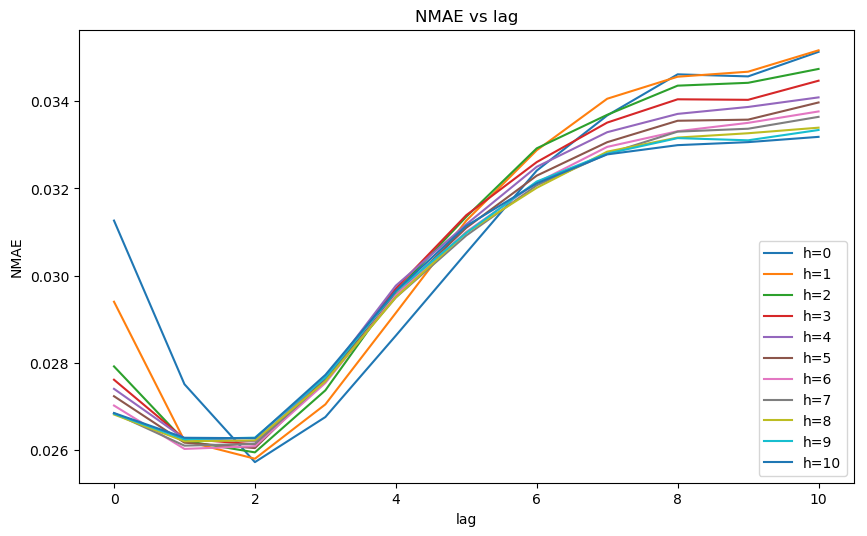

In [94]:
fig, linep_ = plt.subplots(figsize = (10,6), dpi = 100)

linep_ = sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l0", label="h=0")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l1", label="h=1")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l2", label="h=2")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l3", label="h=3")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l4", label="h=4")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l5", label="h=5")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l6", label="h=6")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l7", label="h=7")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l8", label="h=8")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l9", label="h=9")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l10", label="h=10")
linep_.set(title="NMAE vs lag")

linep_.set(xlabel='lag', ylabel='NMAE')

In [95]:
fig.savefig('lags.png', dpi=300, bbox_inches='tight')